<b>Objective:</b> The main objective of this dataset is to assess and predict water potability based on water quality attributes. It can be used for evaluating the safety and suitability of water sources for human consumption, making informed decisions about water treatment, and ensuring compliance with water quality standards.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from util import cap_outliers_percentile, impute_median
from models.random_forest import RandomForest
from models.xg_boost import XGBoost
from models.light_gbm import LightGBM
import shap

In [2]:
seed = 1000
np.random.seed(seed)
random.seed(seed)

### Load Data

In [3]:
path = kagglehub.dataset_download("uom190346a/water-quality-and-potability")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

Files: ['water_potability.csv']


In [4]:
df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [6]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


<b> Correlation Matrix </b>  
Based on the Correlation matrix, there's no strong collinearity among the features

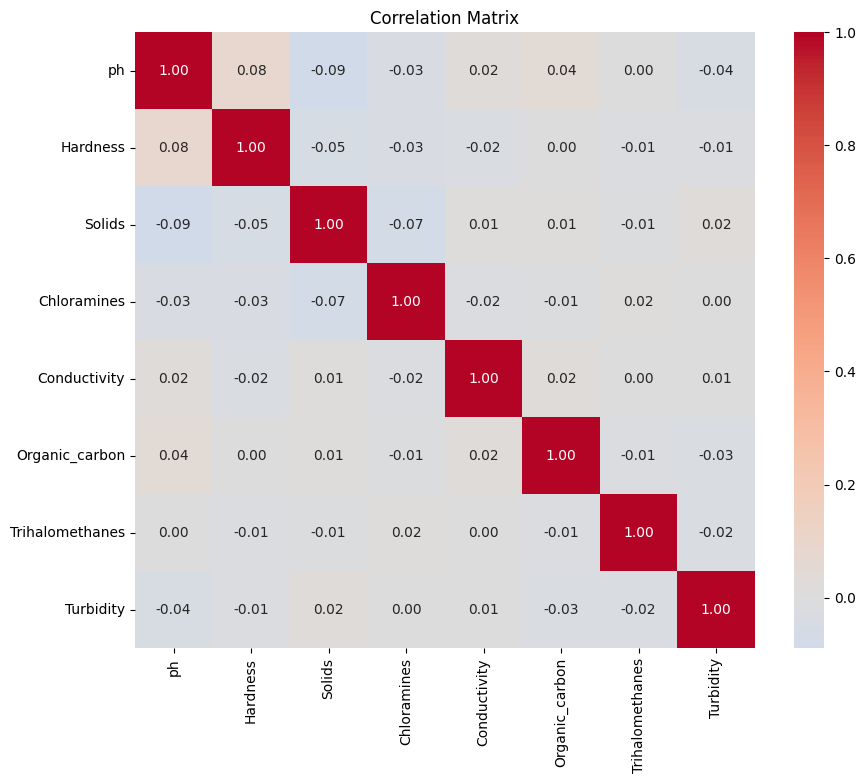

In [7]:
corr = df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity',
          'Organic_carbon', 'Trihalomethanes', 'Turbidity']].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Matrix")
plt.show()

<b> Based on the histograms below, the features generally appear to follow a normal distribution. </b>

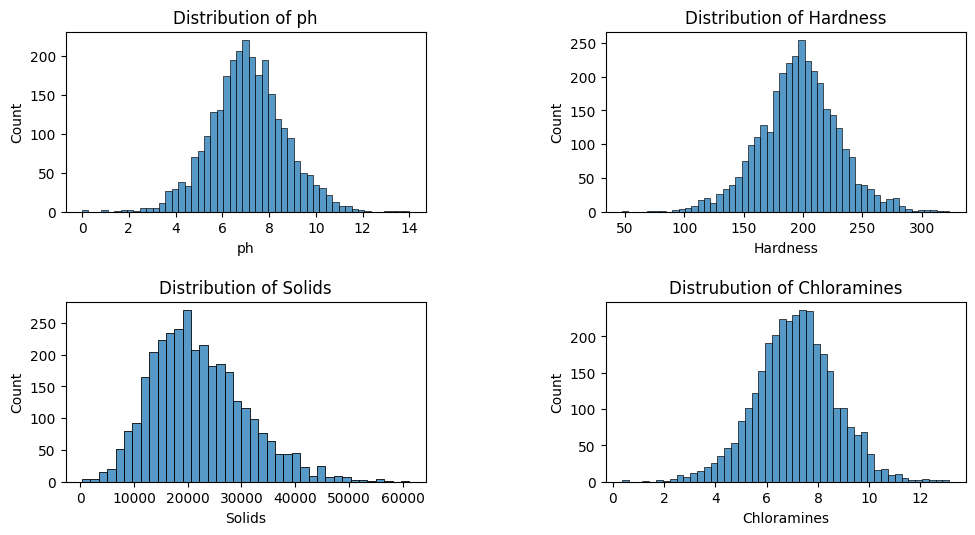

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['ph']).set(title='Distribution of ph')

plt.subplot(2,2,2)
sns.histplot(df['Hardness']).set(title='Distribution of Hardness')

plt.subplot(2,2,3)
sns.histplot(df['Solids']).set(title='Distribution of Solids')

plt.subplot(2,2,4)
sns.histplot(df['Chloramines']).set(title='Distrubution of Chloramines')

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

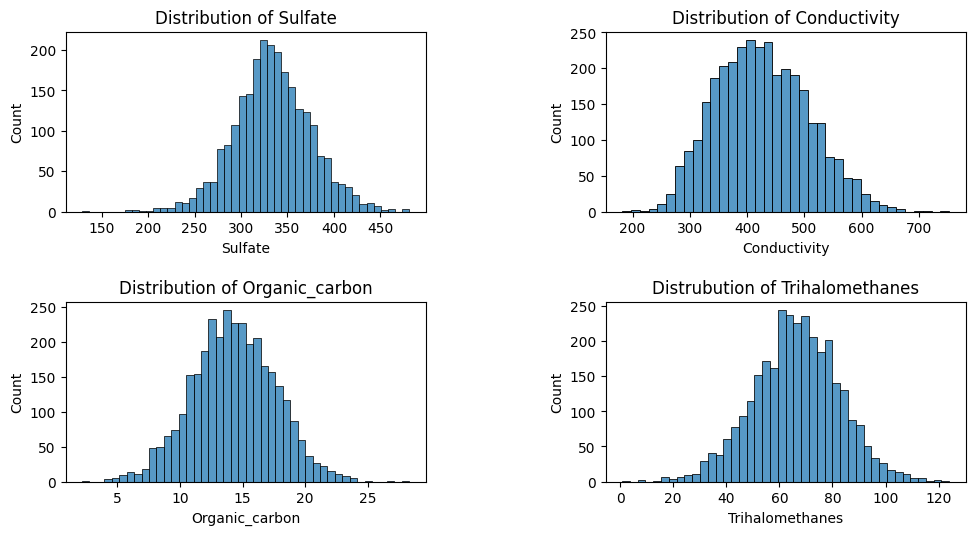

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['Sulfate']).set(title='Distribution of Sulfate')

plt.subplot(2,2,2)
sns.histplot(df['Conductivity']).set(title='Distribution of Conductivity')

plt.subplot(2,2,3)
sns.histplot(df['Organic_carbon']).set(title='Distribution of Organic_carbon')

plt.subplot(2,2,4)
sns.histplot(df['Trihalomethanes']).set(title='Distrubution of Trihalomethanes')

plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.5, 
                    hspace=0.5)
plt.show()

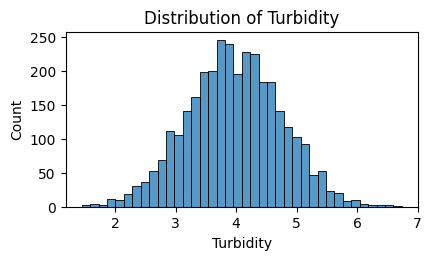

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)
sns.histplot(df['Turbidity']).set(title='Distribution of Turbidity')
plt.show()

In [11]:
print(list(df.columns))

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']


<b> Remove outliers using Winsorization(percentile capping) </b>

In [12]:
# Remove outliers using Winsorization(percentile capping)
continuos_vars = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Sulfate', 'Trihalomethanes', 'Turbidity']
df = cap_outliers_percentile(df, continuos_vars)

<b> Check for missing values </b>

In [13]:
missing_summary = (
    df.isna()
      .mean()
      .mul(100)
      .reset_index(name="missing_percentage")
      .rename(columns={"index": "column"})
)

print(missing_summary)

            column  missing_percentage
0               ph           14.987790
1         Hardness            0.000000
2           Solids            0.000000
3      Chloramines            0.000000
4          Sulfate           23.840049
5     Conductivity            0.000000
6   Organic_carbon            0.000000
7  Trihalomethanes            4.945055
8        Turbidity            0.000000
9       Potability            0.000000


<b> Impute missing values in each column with the median. The feature Sulfate will be dropped from the model due to have 23.84% missing values </b>

In [14]:
df = df.drop('Sulfate', axis=1)
df = impute_median(df, ['ph', 'Trihalomethanes'])

In [15]:
missing_summary = (
    df.isna()
      .mean()
      .mul(100)
      .reset_index(name="missing_percentage")
      .rename(columns={"index": "column"})
)

print(missing_summary)

            column  missing_percentage
0               ph                 0.0
1         Hardness                 0.0
2           Solids                 0.0
3      Chloramines                 0.0
4     Conductivity                 0.0
5   Organic_carbon                 0.0
6  Trihalomethanes                 0.0
7        Turbidity                 0.0
8       Potability                 0.0


<b> Check Class imbalance in the target variable </b>  
There's almost twice as many observations without potable water.

In [16]:
class_dist = pd.DataFrame({
    "count": df['Potability'].value_counts(),
    "percentage": (df['Potability'].value_counts(normalize=True) * 100).round(2)
})

class_dist

,count,percentage
Potability,,
0,1998,60.99
1,1278,39.01


#### Feature Engineering

In [17]:
df['sol_chlo_ratio'] = df['Solids'] / df['Chloramines']
df['cond_carbon_ratio'] = df['Conductivity'] / df['Organic_carbon']
df['tri_turb_ratio'] = df['Trihalomethanes'] / df['Turbidity']

#### Split Data into Train, Validation, Test

In [18]:
print(list(df.columns))

['ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability', 'sol_chlo_ratio', 'cond_carbon_ratio', 'tri_turb_ratio']


In [19]:
pred_cols = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 
             'Organic_carbon', 'Trihalomethanes', 'Turbidity',
             'sol_chlo_ratio', 'cond_carbon_ratio', 'tri_turb_ratio']
target_col = "Potability"

X = df[pred_cols]
y = df[target_col]

# 70% train+val, 30% test
X_temp, X_test, y_temp, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size=0.30, 
                                                  random_state=seed, 
                                                  stratify=y)

# Split train+val into train and validation (70/30 split of remaining)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.30, random_state=seed,stratify=y_temp)


## Train Models

<b>Random Forest </b>

In [20]:
rf = RandomForest()
best_params = rf.tune_classifier(X=X_train, y=y_train)

tuned_rf_clf, best_params = rf.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_rf_clf.predict_proba(X_val)
rf_auc_val = rf.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {rf_auc_val}")

100%|██████████| 100/100 [05:17<00:00,  3.18s/trial, best loss: -0.6065181464038607]
Validation AUC ROC: 0.591095811411486


<b> XGBoost </b>

In [21]:
xg = XGBoost()
best_params = xg.tune_classifier(X=X_train, y=y_train)

tuned_xg_clf, best_params = xg.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_xg_clf.predict_proba(X_val)
xg_auc_val = xg.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {xg_auc_val}")

100%|██████████| 100/100 [01:54<00:00,  1.14s/trial, best loss: -0.6049685446828305]
Validation AUC ROC: 0.560947911029092


<b> LightGBM </b>

In [22]:
lgbm = LightGBM()
best_params = lgbm.tune_classifier(X=X_train, y=y_train)

tuned_lgbm_clf, best_params = lgbm.fit_classifier(X=X_train, y=y_train, best=best_params)
y_pred = tuned_lgbm_clf.predict_proba(X_val)
lgbm_auc_val = lgbm.compute_auc(y_val, y_pred[:, 1])
print(f"Validation AUC ROC: {lgbm_auc_val}")

100%|██████████| 100/100 [07:53<00:00,  4.74s/trial, best loss: -0.5998265247979534]
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

### Final Model

Random Forest model had the best performance on the validation set and therefore was selected as the final model 

In [23]:
y_pred = tuned_rf_clf.predict_proba(X_test)
rf_auc_test = rf.compute_auc(y_test, y_pred[:, 1])
print(f"Validation AUC ROC: {rf_auc_test}")

Validation AUC ROC: 0.6033072236727589


The most important predictors in determining potable water are ph, Chloramines, ratio of (Solids and Chloramines).

C:\Users\syarn\AppData\Local\Temp\ipykernel_29072\1341001193.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test)


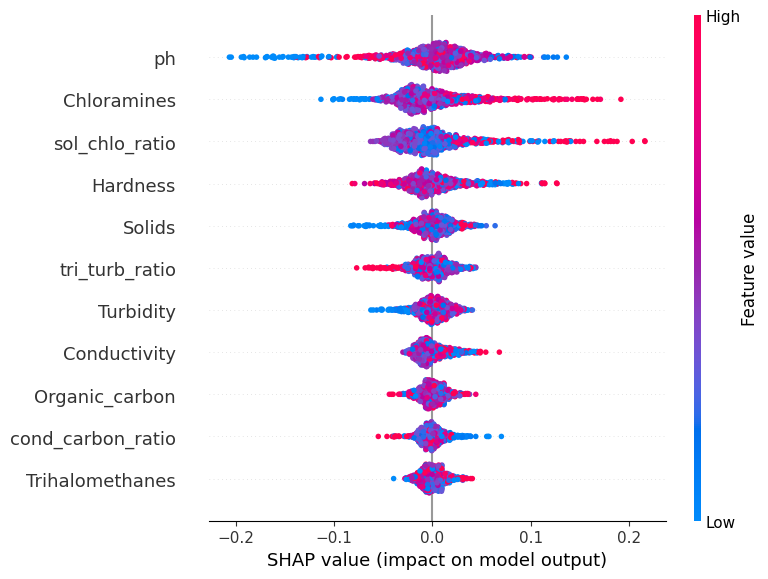

In [24]:
# 2. Create a SHAP explainer (TreeExplainer is efficient for tree models)
explainer = shap.TreeExplainer(tuned_rf_clf)

# 3. Calculate SHAP values
shap_values = explainer(X_test) 

shap.summary_plot(shap_values[:, :, 1], X_test)